5 W and H

- Why should we learn to handle noisy and imbalanced datasets
    - Noise: Most real world datasets will have some noise since the labels may not be expert generated, or due to equipment issues.
    - Imbalance: Lots of datasets like fraud/disease detection have very low positive rates but lots of data

- Why we did with concepts
- What we did
- What impact/difference it made in perf?
- Allow other datasets like titanic and housing price to be used by making modular.
- provide interactive controls for both model and data generation
- Provide ways to visualize these issues and show how we can leverage this on a real world dataset.
- After Classification show correct and erroroneous classification
- Enable plotting of results of various experiments overall. 
    - Noise plot: Increase noise how does metric change
    - Imbalance plot: Increase imbalance how does metric change
    
- Put well commented `your X here` for other people to experiment

# References

[Install Imbalanced Learn](https://imbalanced-learn.readthedocs.io/en/stable/install.html)

`conda install -y -c anaconda py-xgboost`

`conda install -y -c conda-forge xgboost`

`pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master`

`pip install keras`

`pip install tensorflow`

`pip install missingno`

# Different Noise and Imbalance combinations

- No Noise
    - No Imbalance
    - Imbalance
        - No Oversampling
        - Oversampling
- Random Noise
    - No Imbalance
    - Imbalance
        - No Oversampling
        - Oversampling
- Boundary Noise
    - No Imbalance
    - Imbalance
        - No Oversampling
        - Oversampling
- Data Noise

# Dealing with Noisy Labels 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
from matplotlib import pyplot as plt

import pandas as pd
from pandas import DataFrame
import more_itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.impute import SimpleImputer

from multiprocessing import Pool
from xgboost import XGBClassifier
import multiprocessing

pd.options.display.max_rows=900
pd.options.display.max_columns=900

%matplotlib inline
import seaborn as sns
from IPython.display import display

from data_science_utils import dataframe as df_utils
from data_science_utils import models as model_utils
from data_science_utils import plots as plot_utils
from data_science_utils.dataframe import column as column_utils
from data_science_utils import misc as misc
from data_science_utils import preprocessing as pp_utils

import warnings
import traceback
np.set_printoptions(threshold=np.nan)
warnings.filterwarnings('ignore')
import sys, os
import missingno as msno
import random
import gc

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)




[nltk_data] Downloading package punkt to /Users/ahemf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ahemf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ahemf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ahemf/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw to /Users/ahemf/nltk_data...
[nltk_data]   Package omw is already up-to-date!
Using TensorFlow backend.


[XGBoost validation plots](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/)

- Signal to Noise Ratio
    - stopwords in NLP
    - Images and Denoising Auto-Encoders
- Importance of knowing noise levels in your data. This determines the maximum accuracy/other metric that your model can perform.
- Recognizing the type of noise. 
    - Is it near the decision boundary (few ambigous samples marked wrong). This is good, most models are robust to this.
    - Is it randomly spread (Makes things hard)
- Seeing how imbalance combined with noise impact performance.
    - Choosing the right metric for class imbalance problems. e.g. FP rate, AP, instead of Accuracy.
        - Show this by plotting imbalance in x-axis and metric in y for multiple metrics
    - Notice how adding imbalance makes it difficult for model to get both high precision and recall.
    - Adding over-sampling methods for NNs and scale_pos_weight for XGBoost to deal with class imabalance. We will try dumb oversampling only.
    - At what point of imbalance does over-sampling help, and what does it imply for our metrics
    
- Precautions to take while over-sampling in presence of noise.
- Recognising overfit especially in boundary noise conditions and imbalance by using Cross Validation.


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from data_science_utils.dataframe import get_specific_cols

from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import BaseWrapper
from keras.layers import Dense, Activation
from keras import optimizers
from keras import backend as K
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TerminateOnNaN

_EPSILON = K.epsilon()

def log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    return K.mean(out, axis=-1)

def root_mean_squared_error(y_true, y_pred):
    # error = K.square((1-y_true)*(y_pred - y_true)+(4*y_true)*(y_pred - y_true))
    error = K.square((y_pred - y_true))
    return K.sqrt(K.mean(error, axis=-1))

class BinaryClassifierKerasDNN:
    def __init__(self, network_config,lr=0.005,
                 n_iter=[500,500,500], columns=[],
                 scale_input=True, impute=True, raise_null=True,verbose=False,plot=True):
        self.network_config = network_config
        self.columns = columns
        assert len(columns) > 0 or prefixes is not None
        self.scale_input = scale_input
        self.scaler = StandardScaler()
        self.impute = impute
        self.imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        self.imp_inf = SimpleImputer(missing_values=np.inf, strategy='mean')
        self.raise_null = raise_null
        self.cols = None
        self.n_iter = n_iter
        self.verbose = verbose
        self.plot = plot
        self.lr = lr

    def check_null_(self, X):
        nans = np.isnan(X)
        infs = np.isinf(X)
        nan_summary = np.sum(np.logical_or(nans, infs))
        if nan_summary > 0:
            raise ValueError("nans/inf in frame = %s" % (nan_summary))

    def get_cols_(self, X):
        cols = list(self.columns)
        return cols

    def fit(self, X, y, sample_weight=None):
        cols = self.get_cols_(X)
        self.cols = cols
        X = X[cols]
                
        from sklearn.utils import shuffle
        X, y = shuffle(X, y)
            
            
        if self.impute:
            X = self.imp.fit_transform(X)
            X = self.imp_inf.fit_transform(X)
        if self.scale_input:
            X = self.scaler.fit_transform(X)
        if self.raise_null:
            self.check_null_(X)
            
        model = Sequential()
        i = 0
        for layer in self.network_config:
            if i==0:
                model.add(Dense(layer['neurons'],activation=layer['activation'],input_dim=X.shape[1],use_bias=True))
                if "dropout" in layer:
                    model.add(Dropout(layer["dropout"]))
                else:
                    model.add(Dropout(0.2))
            else:
                model.add(Dense(layer['neurons'],activation=layer['activation'],use_bias=True))
                if "dropout" in layer:
                    model.add(Dropout(layer["dropout"]))
                else:
                    model.add(Dropout(0.1))
            i=i+1
        model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
        
        adam = optimizers.Adam(lr=self.lr, clipnorm=2, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
        model.compile(optimizer=adam, loss=log_loss)
        
        
        X1,X2,X3 = np.split(X, [int(.33*len(X)), int(.66*len(X))])
        y1,y2,y3 = np.split(y, [int(.33*len(y)), int(.66*len(y))])
        
        X1,X2,X3 = pd.DataFrame(X1),pd.DataFrame(X2),pd.DataFrame(X3)
        y1,y2,y3 = pd.Series(y1),pd.Series(y2),pd.Series(y3)
        
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0000005,epsilon=0.0001)
        reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=3, min_lr=0.0000005,epsilon=0.00001)
        terminate_on_nan = TerminateOnNaN()
        es = EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=12, verbose=0,)
        es2 = EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=10, verbose=0,)
        # print(K.get_value(model.optimizer.lr))
        X_train,y_train,X_val,y_val = pd.concat((X1,X2),axis=0),pd.concat((y1,y2),axis=0),X3,y3
        training_loss = []
        test_loss = []
        history = model.fit(X_train, y_train,
                        epochs=self.n_iter[0],
                        batch_size=1024,
                        shuffle=True,
                        validation_data=(X_val, y_val),
                        verbose=self.verbose,
                        callbacks=[es,terminate_on_nan,reduce_lr])
        training_loss.extend(history.history['loss'])
        test_loss.extend(history.history['val_loss'])
        # K.set_value(model.optimizer.lr, self.lr/2)
        # print(K.get_value(model.optimizer.lr))
        
        X_train,y_train,X_val,y_val = pd.concat((X2,X3),axis=0),pd.concat((y2,y3),axis=0),X1,y1
        history = model.fit(X_train, y_train,
                        epochs=self.n_iter[1],
                        batch_size=1024,
                        shuffle=True,
                        validation_data=(X_val, y_val),
                        verbose=self.verbose,
                        callbacks=[es2,terminate_on_nan,reduce_lr2])
        training_loss.extend(history.history['loss'])
        test_loss.extend(history.history['val_loss'])
        
        # print(K.get_value(model.optimizer.lr))
        K.set_value(model.optimizer.lr, self.lr/100)
        # print(K.get_value(model.optimizer.lr))
        
        X_train,y_train,X_val,y_val = pd.concat((X1,X3),axis=0),pd.concat((y1,y3),axis=0),X2,y2
        history = model.fit(X_train, y_train,
                        epochs=self.n_iter[2],
                        batch_size=4096,
                        shuffle=True,
                        validation_data=(X_val, y_val),
                        verbose=self.verbose,
                        callbacks=[es2,terminate_on_nan,reduce_lr2])
        training_loss.extend(history.history['loss'])
        test_loss.extend(history.history['val_loss'])
        # print(K.get_value(model.optimizer.lr))
        
        if self.plot:
            plt.figure(figsize=(14,10))
            plt.plot(training_loss,label="Training Loss")
            plt.plot(test_loss,label="Test Loss")
            plt.title("Training and Test Loss (Last 3 Training): %s (Last 3 Test): %s"%(training_loss[-3:],test_loss[-3:]))
            plt.ylim((min(min(training_loss),min(test_loss)),min(max(training_loss),max(test_loss))))
            plt.legend()
            plt.show()
        
        
        gc.collect()
        self.classifier = model
        return self

    def partial_fit(self, X, y):
        return self.fit(X, y)

    def predict_proba(self, X, y='ignored'):
        Inp = X
        cols = self.cols
        Inp = Inp[cols]
        if self.impute:
            Inp = self.imp.transform(Inp)
            Inp = self.imp_inf.transform(Inp)
        if self.scale_input:
            Inp = self.scaler.transform(Inp)

        if self.raise_null:
            self.check_null_(Inp)
        probas = self.classifier.predict(Inp)
        gc.collect()
        return probas
    
    def predict(self,X,y='ignored'):
        return self.predict_proba(X)>0.5

    def inverse_transform(self, X, copy=None):
        raise NotImplementedError()

    def fit_transform(self, X, y, sample_weight=None):
        self.fit(X, y, sample_weight=sample_weight)
        return self.transform(X, y)

In [243]:
from imblearn.datasets import make_imbalance
from collections import Counter

def verify_pandas(X,y):
    if type(X)!=pd.DataFrame:
        raise ValueError("Only Pandas Dataframe supported for X")
    if type(y)!=pd.Series:
        raise ValueError("Only Pandas Series Supported for y")

def plot_pie(y,ax=None):
    target_stats = Counter(y)
    labels = sorted(list(target_stats.keys()))
    sizes = list([target_stats[label] for label in labels])
    explode = tuple([0.01] * len(target_stats))

    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct, v=val)
        return my_autopct

    if ax is None:
        fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct=make_autopct(sizes))
    ax.axis('equal')

def generate_data(data_size = 10000, # before imbalance, approx
                x_min_max = 35,
                shape_param_1 = 5, # try values like 3,5,7,[10] and see how graph changes
                shape_param_2 = 10, # try 5,10,15,20
                shape_param_3 = 1.5, # try between 1-5
                shape_param_4 = 100, # try 50,100,150,200
                add_shapes_for_extra_complexity = True,
                plot=False):
    
    min_x,max_x = -x_min_max,x_min_max
    interval = (max_x-min_x)/data_size
    x = np.arange(min_x,max_x,interval)
    y_line = np.clip((x**3)/shape_param_4 - shape_param_1*x + shape_param_2*np.sin(x/shape_param_3),-80,80)
    
    y = np.random.uniform(min(y_line)-10,max(y_line)+10,len(x))
    target = y>y_line
    if add_shapes_for_extra_complexity:
        circle1 = np.where((x-10)**2 + (y-33)**2 < 81)
        target[circle1] = ~(np.mean(target[circle1])>0.5)
        
        circle2 = np.where((x+10)**2 + (y+47)**2 < 64)
        target[circle2] = ~(np.mean(target[circle2])>0.5)
        circle3 = np.where((x-25)**2 + (y+70)**2 < 100)
        target[circle3] = ~(np.mean(target[circle3])>0.5)
        
        circle4 = np.where((x+20)**2 + (y-70)**2 < 49)
        target[circle4] = ~(np.mean(target[circle4])>0.5)
        
    X = pd.DataFrame({"x":x,"y":y})
    
    if plot:
    
        plt.figure(figsize=(14,5));
        sns.lineplot(x,y_line);
        sns.scatterplot(x,y,hue=target);
        plt.title("Data: Ratio +/- = %.3f"%(np.sum(target)/np.sum(~target)));
        plt.show();
    
    return X,pd.Series(target)

def plot_imbalance(y,y_res):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
    # pie chart
    
    plot_pie(y,ax1)
    plot_pie(y_res,ax2)
    ax1.set_title("Target before Imbalance")
    ax2.set_title("Target after Imbalance")
    
    plt.show()
    
def imbalance(X,y,pos_neg_frac, plot=False):
    verify_pandas(X,y)
    pos_examples = np.sum(y)
    negative_examples = np.sum([False if yew else True for yew in y])
    pos_neg_frac_now = pos_examples/negative_examples
    if pos_neg_frac_now<=pos_neg_frac:
        print("WARN: Data is already imbalanced! Imbalance = %.4f Try oversampling"%(pos_neg_frac_now))
        return X,y
    
    num_pos_examples_needed = int(pos_neg_frac*negative_examples)
    X_res,y_res = make_imbalance(X, y,sampling_strategy={0: negative_examples, 1: num_pos_examples_needed})
    X_res = pd.DataFrame(X_res)
    y_res=pd.Series(y_res)
    if plot:
        if X.shape[1] == 2:
            f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(18,9))
            sns.scatterplot(X.values[:,0],X.values[:,1],hue=y,ax=ax1);
            ax1.set_title("Before Imbalance");
            
            sns.scatterplot(X_res.values[:,0],X_res.values[:,1],hue=y_res,ax=ax2);
            ax2.set_title("After Imbalance");
            plt.show();

        print("="*100)
        plot_imbalance(y,y_res)
        
    
    return X_res,y_res

def plot_reduced_dim(X,y,X_res,y_res):
    from sklearn.manifold import TSNE
    verify_pandas(X,y)
    
    if X.shape[1]>2:
        X_embedded = TSNE(n_components=2,random_state=47,n_iter=400,angle=0.6).fit_transform(X)
        X_embedded_res = TSNE(n_components=2,random_state=47,n_iter=400,angle=0.6).fit_transform(X_res)
    else:
        X_embedded = X.values
        X_embedded_res = X_res.values
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(18,8))
    #sns.lineplot(x,y_line,ax=ax1);
    sns.scatterplot(X_embedded[:,0],X_embedded[:,1],hue=y,ax=ax1);
    ax1.set_title("Before, Ratio +/- = %.3f"%(np.sum(y)/np.sum(~y)));

    #sns.lineplot(x,y_line,ax=ax2);
    sns.scatterplot(X_embedded_res[:,0],X_embedded_res[:,1],hue=y_res,ax=ax2);
    ax2.set_title("After, Ratio +/- = %.3f"%(np.sum(y_res)/np.sum(~y_res)));
    plt.show();

def add_noise(X,y,noise_level = 0.2,noise_type = "randomize_labels",
              classifier=XGBClassifier(n_estimators=25),plot=False):
    # plotting in 2 component with tsne, plot noised and non noised
    # Show possible max accuracy, precision and recall.
    # for boundary noise we use a classifier to find the boundary
    # randomize_labels|near_decision_boundary_labels|data
    import bisect
    
    verify_pandas(X,y)
    
    
    total_noised_samples_needed = int(len(X)*noise_level)
    noised_indexes = []
    X_res,y_res = X.copy(),y.copy()
    if noise_type is None:
        pass
    elif noise_type=="data":
        for col in X.columns:
            mean = X[col].mean()
            std = X[col].std()*noise_level
            noise = np.random.normal(mean, std, [X.shape[0]])
            X_res[col] = X[col] + std
    elif noise_type=="randomize_labels":
        noised_indexes = np.random.randint(0,len(y),int(noise_level*len(y)))
    elif noise_type=="near_decision_boundary_labels":
        classifier.fit(X,y)
        probas = classifier.predict_proba(X)[:,1]
        sorted_probas = sorted(probas)
        numbers = np.arange(1,len(sorted_probas))
        inverted_numbers = reversed(numbers)
        proba_count_dict = {}
        min_error = len(X)
        final_width = 0.5
        for width in np.arange(0.001,0.499,0.001):
            lower = 0.5 - width
            upper = 0.5 + width
            lidx = bisect.bisect_left(sorted_probas,lower)
            uidx = bisect.bisect_right(sorted_probas,upper)
            length = uidx - lidx
            error = np.abs(3*total_noised_samples_needed-length)
            if error > min_error:
                final_width = width
            min_error = min(min_error,error)
        boundary_indexes = np.where(np.abs(probas-0.5)<final_width)[0]
        index_selector = np.random.randint(0,len(boundary_indexes),total_noised_samples_needed)
        noised_indexes = boundary_indexes[index_selector]
        
        
        
    else:
        raise ValueError("Unknown Noise Type")

    X_res,y_res = pd.DataFrame(X_res,columns=X.columns,index=X.index),pd.Series(y_res,index=y.index)
    
    
    y_res[noised_indexes] = 1 - y_res[noised_indexes]
    if plot:
        print("="*100)
        print("Plots Before and After Noise.\n")
        actual_noise_frac = len(noised_indexes)/len(X)
        sys.stdout.write("\n\rNumber of Target Labels noised = %s, Noise fraction=%.3f"%(len(noised_indexes),actual_noise_frac))
        print("\n\nBest Possible Metrics:")
        print(classification_report(y_res,y))
        plot_reduced_dim(X,y,X_res,y_res)
    
    return X_res,y_res


def oversample(X,y,method="smote",pos_neg_frac=0.2,plot=False):
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import ADASYN
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.combine import SMOTEENN
    from imblearn.combine import SMOTETomek
    sampler = None
    verify_pandas(X,y)
    cols = X.columns
    if method=="smote":
        sampler = SMOTE(sampling_strategy=pos_neg_frac)
    elif method=="adasyn":
        sampler = ADASYN(sampling_strategy=pos_neg_frac)
    elif method=="randomoversampler":
        sampler = RandomOverSampler(sampling_strategy=pos_neg_frac)
    elif method=="smoteenn":
        sampler = SMOTEENN(sampling_strategy=pos_neg_frac)
    elif method=="smotetomek":
        sampler = SMOTETomek(sampling_strategy=pos_neg_frac)
    else:
        raise ValueError("Over sampler not found")
    
    X_res,y_res = X.copy(deep=True),y.copy(deep=True)
    X_res,y_res = sampler.fit_resample(X_res,y_res)
    X_res = pd.DataFrame(X_res,columns=cols)
        
    y_res=pd.Series(y_res)
        
    if plot:
        print("="*100+"\nPlotting Imbalance and Noise after Oversampling")
        plot_imbalance(y,y_res)
        plot_reduced_dim(X,y,X_res,y_res)
    return X_res,y_res


In [221]:

from imblearn.metrics import classification_report_imbalanced

def brier_scorer(y,y_pred,y_pred_proba):
    from sklearn.metrics import brier_score_loss
    return brier_score_loss(y,y_pred)

def balanced_accuracy_scorer(y,y_pred,y_pred_proba):
    from sklearn.metrics import balanced_accuracy_score
    return balanced_accuracy_score(y,y_pred,adjusted=True)


def average_precision_scorer(y,y_pred,y_pred_proba):
    from sklearn.metrics import average_precision_score
    return average_precision_score(y,y_pred_proba)

def precision_scorer(y,y_pred,y_pred_proba):
    from sklearn.metrics import precision_score
    return precision_score(y,y_pred)

def recall_scorer(y,y_pred,y_pred_proba):
    from sklearn.metrics import recall_score
    return recall_score(y,y_pred)

def f1_scorer(y,y_pred,y_pred_proba):
    from sklearn.metrics import f1_score
    return f1_score(y,y_pred)

def accuracy_scorer(y,y_pred,y_pred_proba):
    from sklearn.metrics import accuracy_score
    return accuracy_score(y,y_pred)

def plot_classifier(X_train,y_train,y_pred_train,y_pred_train_proba,
                    X_test,y_test,y_pred,y_pred_proba):
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import accuracy_score
    print("="*100)
    print("Classification Report:")
    print(classification_report_imbalanced(y_test,y_pred))
    print("\nTrain Acc: %.5f, Test Acc: %.5f" %(accuracy_score(y_train,y_pred_train),accuracy_score(y_test,y_pred)))
    print("\nTrain AP: %.5f, Test AP: %.5f" %(average_precision_score(y_train,y_pred_train_proba),average_precision_score(y_test, y_pred_proba)))
    plot_utils.precision_recall_curve_binary(y_train, y_pred_train_proba)
    plot_utils.precision_recall_curve_binary(y_test, y_pred_proba)
    # Plot with TSNE where model is right and wrong
    
    print("\nTSNE Plots of Reduced Dim classification Accuracy")
    plot_reduced_dim(X_train,y_train==y_pred_train,X_test,y_test==y_pred)
    plt.show();
    

def run_classifier(classifier,scorers,X_train,y_train,X_test,y_test,plot=False):
    verify_pandas(X_train,y_train)
    verify_pandas(X_test,y_test)
    
    classifier.fit(X_train,y_train.values);
    y_pred = classifier.predict(X_test)
    y_pred_train = classifier.predict(X_train)
    
    y_pred = y_pred.squeeze()
    y_pred_train = y_pred_train.squeeze()
    
    
    y_pred_proba = classifier.predict_proba(X_test)
    y_pred_train_proba = classifier.predict_proba(X_train)
    if len(y_pred_proba.shape)==2 and y_pred_proba.shape[1]==2:
        y_pred_proba = y_pred_proba[:,1]
        y_pred_train_proba = y_pred_train_proba[:,1]
        
    if plot:
        plot_classifier(X_train,y_train,y_pred_train,y_pred_train_proba,
                    X_test,y_test,y_pred,y_pred_proba)
        
    score_dict = {}
    for scorer in scorers:
        score_dict[scorer.__name__] = [scorer(y_train,y_pred_train,y_pred_train_proba),scorer(y_test,y_pred,y_pred_proba)]
        
    return score_dict

    



In [5]:
def split(X,y,test_size=0.3):
    verify_pandas(X,y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train, X_test = pd.DataFrame(X_train,columns=X.columns), pd.DataFrame(X_test,columns=X.columns)
    y_train, y_test =  pd.Series(y_train), pd.Series(y_test)
    return X_train, X_test, y_train, y_test
    

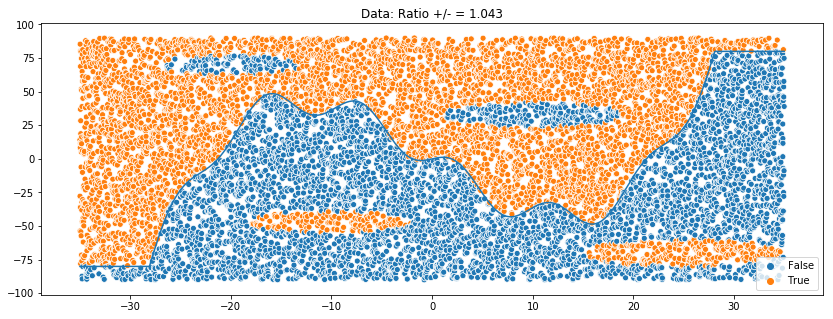

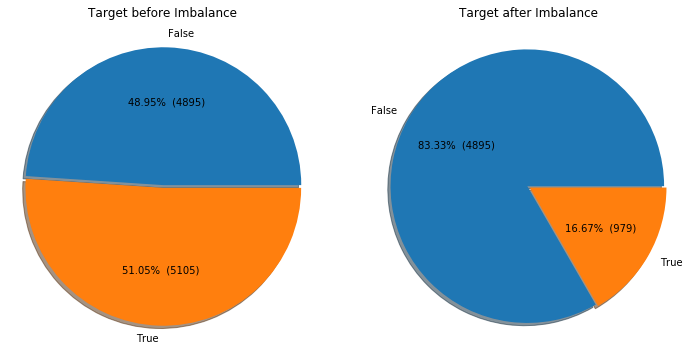

Plots Before and After Noise.


Number of Target Labels noised = 1174, Noise fraction=0.200

Best Possible Metrics:
              precision    recall  f1-score   support

       False       0.82      0.96      0.88      4177
        True       0.82      0.47      0.60      1697

   micro avg       0.82      0.82      0.82      5874
   macro avg       0.82      0.72      0.74      5874
weighted avg       0.82      0.82      0.80      5874



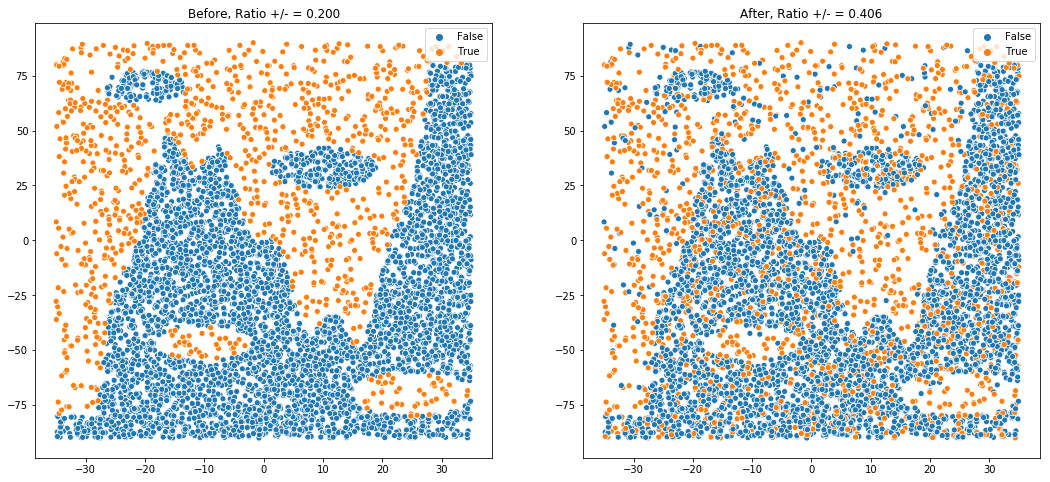

Plotting Imbalance and Noise after Oversampling


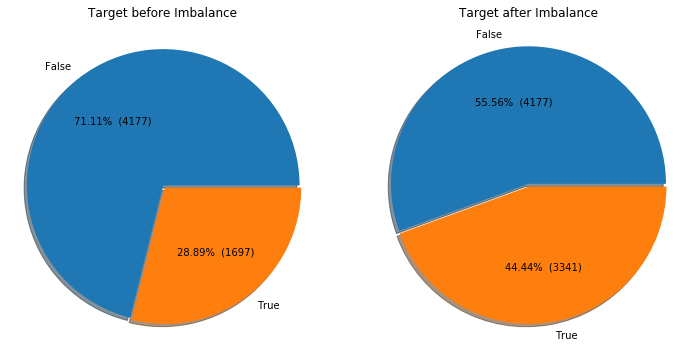

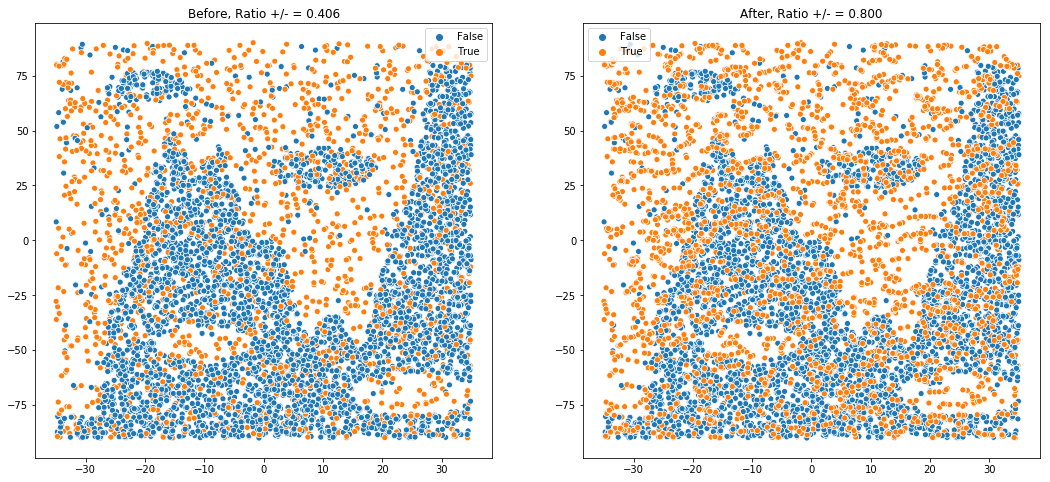

In [230]:
X,y = generate_data(10000,plot=True)
X,y = imbalance(X,y,pos_neg_frac=0.2,plot=True)
X,y = add_noise(X,y,noise_level = 0.2,noise_type = "randomize_labels",plot=True)
X,y = oversample(X,y,pos_neg_frac=0.8,plot=True)
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3)

# Models

Plots Before and After Noise.


Number of Target Labels noised = 1182, Noise fraction=0.200

Best Possible Metrics:
              precision    recall  f1-score   support

       False       0.82      0.95      0.88      4245
        True       0.80      0.47      0.60      1666

   micro avg       0.82      0.82      0.82      5911
   macro avg       0.81      0.71      0.74      5911
weighted avg       0.82      0.82      0.80      5911



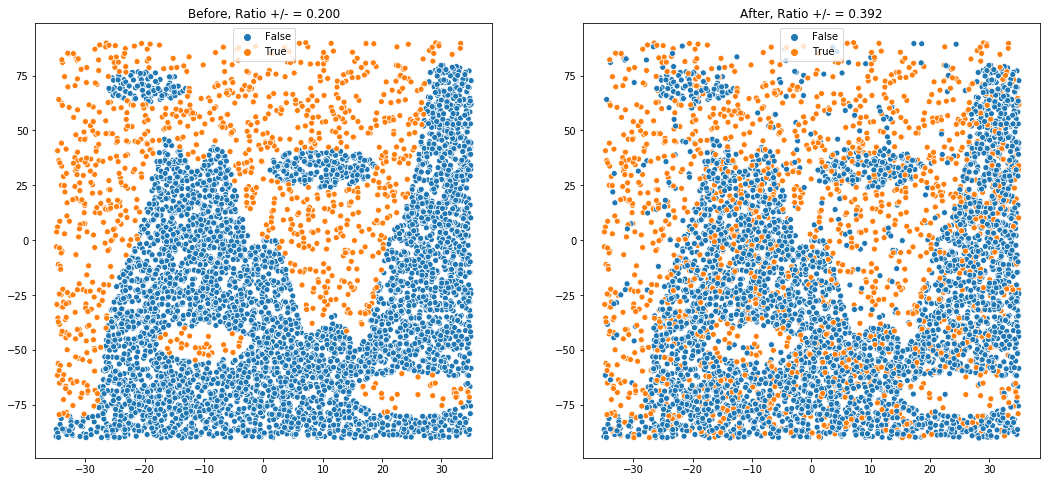

In [231]:
X,y = generate_data(plot=False)
X,y = imbalance(X,y,pos_neg_frac=0.2,plot=False)
X,y = add_noise(X,y,noise_level = 0.2,noise_type = "randomize_labels",plot=True)
X,y = oversample(X,y,pos_neg_frac=0.8,plot=False)
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3)

## AdaBoost

Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

      False       0.69      0.85      0.50      0.76      0.65      0.44      1289
       True       0.72      0.50      0.85      0.59      0.65      0.41      1004

avg / total       0.70      0.70      0.65      0.69      0.65      0.43      2293


Train Acc: 0.66960, Test Acc: 0.69690

Train AP: 0.68838, Test AP: 0.68933


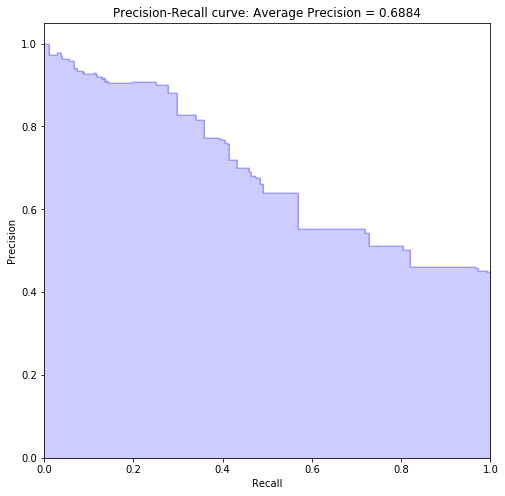

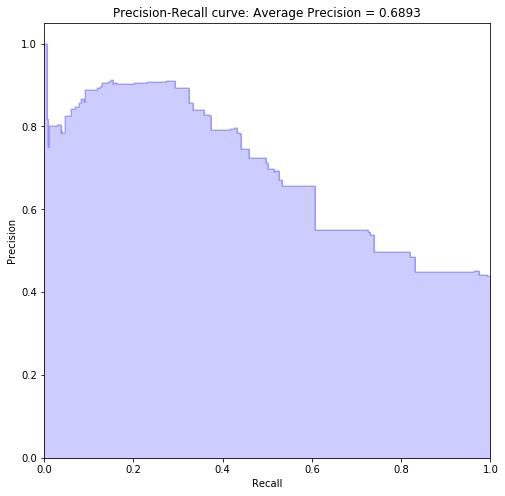


TSNE Plots of Reduced Dim classification Accuracy


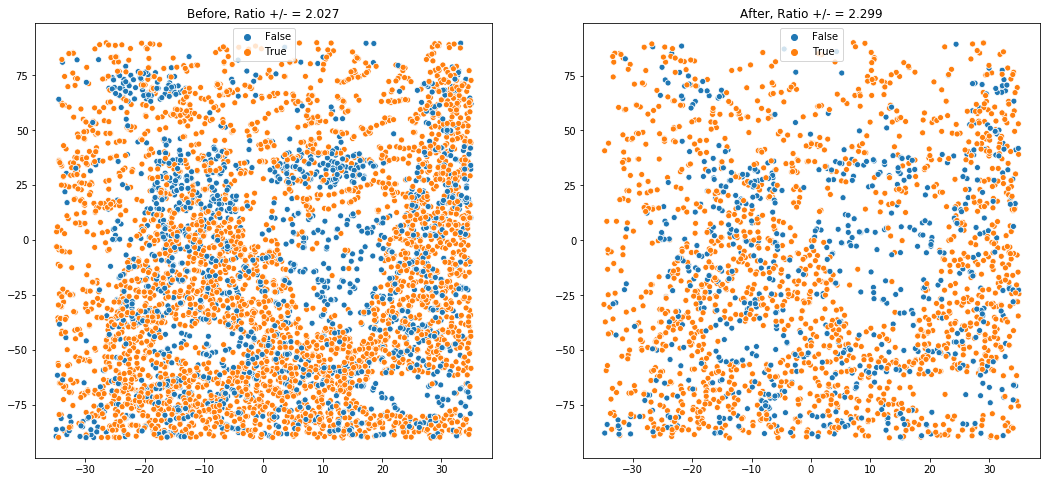

{'average_precision_scorer': [0.6883826748632621, 0.6893281287582861]}

In [232]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                         algorithm="SAMME",
                         n_estimators=20)

run_classifier(classifier,[average_precision_scorer],X_train,y_train,X_test,y_test,plot=True)


## DNN

6.1035155e-07
5e-05
Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

      False       0.68      0.95      0.44      0.79      0.65      0.44      1280
       True       0.87      0.44      0.95      0.58      0.65      0.40      1038

avg / total       0.76      0.72      0.67      0.70      0.65      0.42      2318


Train Acc: 0.74533, Test Acc: 0.71959

Train AP: 0.74154, Test AP: 0.72066


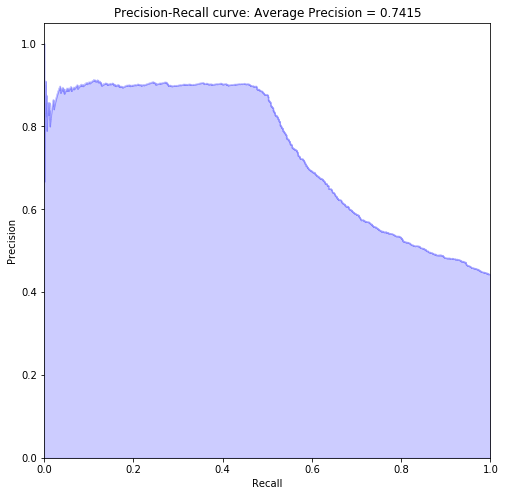

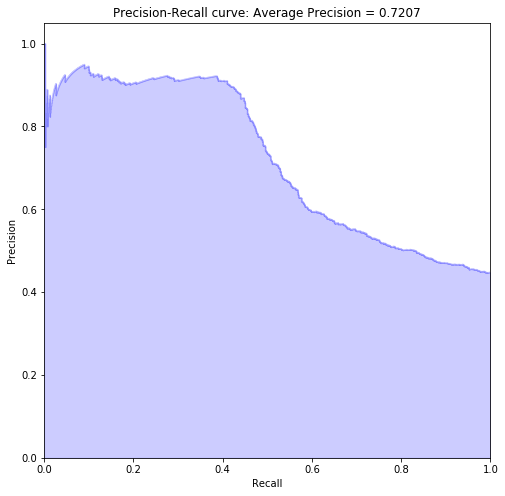


TSNE Plots of Reduced Dim classification Accuracy


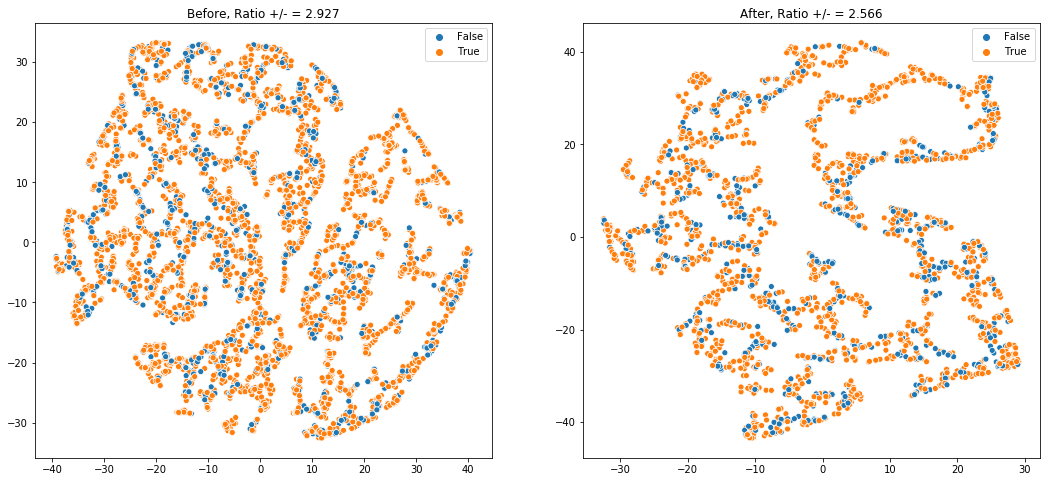

(0.7415390308846775, 0.7206551153749777)

In [14]:
network_config = [{'neurons':1024,'activation':'relu',"dropout":0.3},
                  {'neurons':1024,'activation':'relu',"dropout":0.1},
                  {'neurons':512,'activation':'relu',"dropout":0.1},
                  {'neurons':256,'activation':'selu',"dropout":0},
                  {'neurons':64,'activation':'selu',"dropout":0}]

nn = BinaryClassifierKerasDNN(network_config,lr=0.005,columns=X_train.columns)
run_classifier(nn,average_precision_scorer,X_train,y_train,X_test,y_test,plot=True)


## Oversampling in presence of Noise

Oversampling is ok if there is Random Noise

Why oversampling is bad for errors near boundary?

In case of errors near boundary:
Notice how in presence of noise the decision boundary shifts towards the majority class. This occurs because while error is present in both classes, the majority class has more examples. As a result majority class has more errors near the boundary. These errors simply mean that within the area of majority class and near the border, it will have multiple samples marked as minority class.
Now if we over-sample minority class, and since over-samples usually use nearest neighbors, these border areas will get a lot of minority class examples on the wrong side.

### How do we know if we have noise near decision boundary or random noise?



## Imbalanced Learn Classifiers

(3165, 2)
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.85      0.91      2823
        True       0.43      0.96      0.59       342

   micro avg       0.86      0.86      0.86      3165
   macro avg       0.71      0.90      0.75      3165
weighted avg       0.93      0.86      0.88      3165


Train Acc: 0.86254, Test Acc: 0.85750

Train AP: 0.74188, Test AP: 0.71952


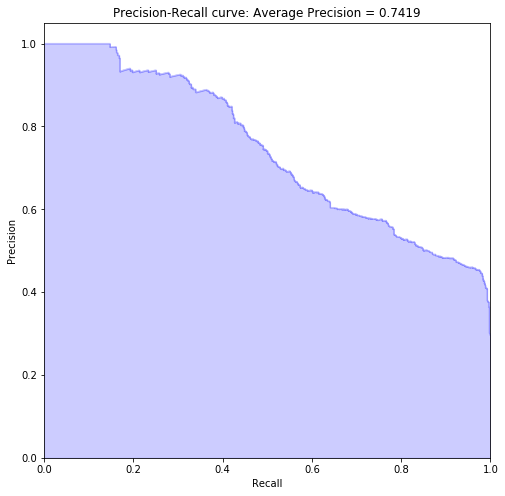

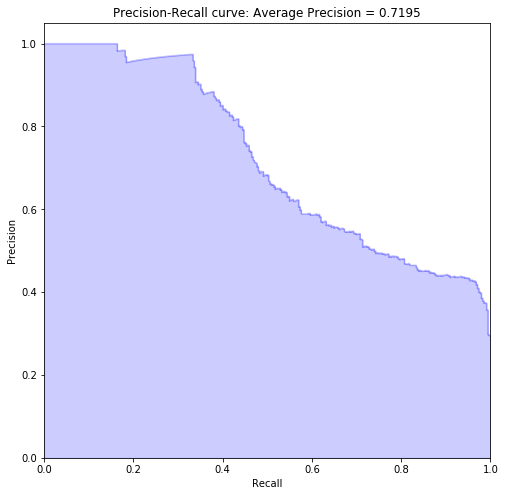

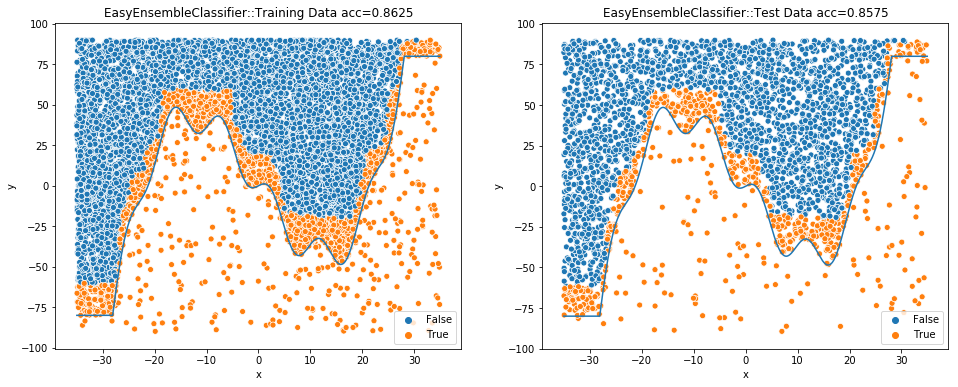

In [15]:
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(n_estimators=100, warm_start=False, sampling_strategy='auto', replacement=False, n_jobs=16)
run_classifier(eec,X_train,y_train,X_test,y_test)


(3165, 2)
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.88      0.93      2823
        True       0.47      0.89      0.61       342

   micro avg       0.88      0.88      0.88      3165
   macro avg       0.73      0.88      0.77      3165
weighted avg       0.93      0.88      0.89      3165


Train Acc: 0.91170, Test Acc: 0.87962

Train AP: 0.87429, Test AP: 0.56503


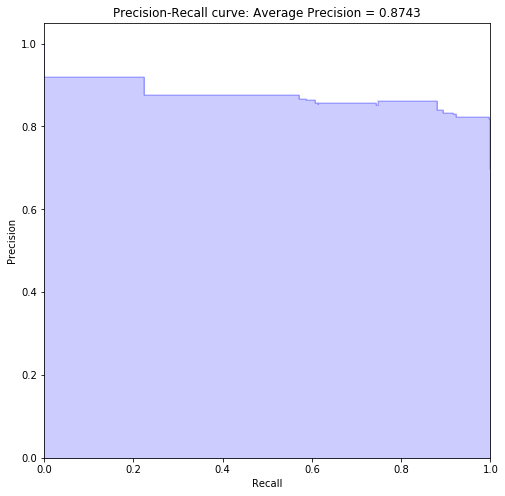

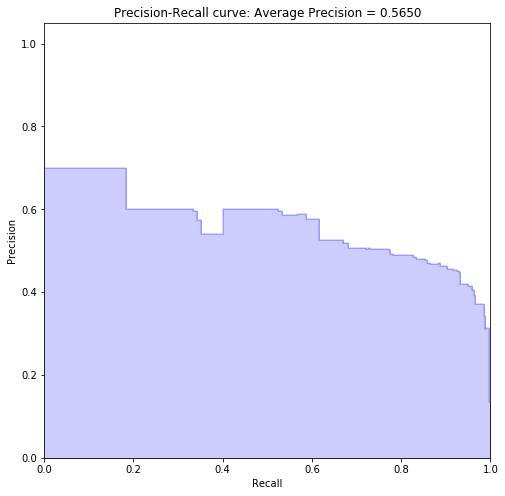

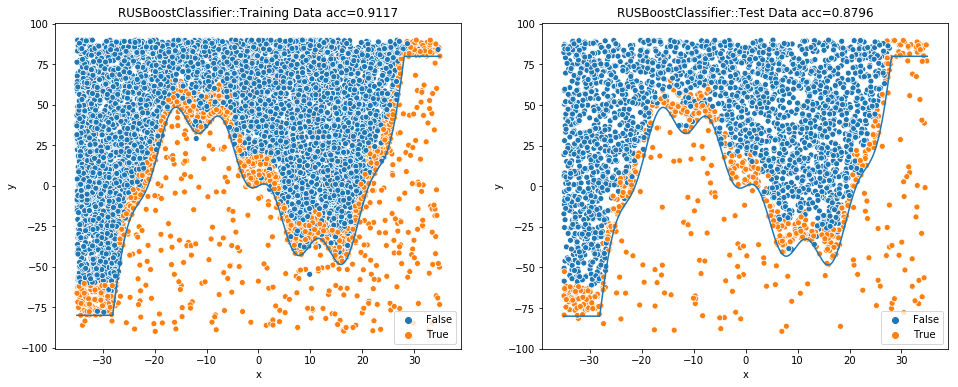

In [20]:
from imblearn.ensemble import RUSBoostClassifier

eec = RUSBoostClassifier(n_estimators=10, learning_rate=0.1, algorithm='SAMME.R', sampling_strategy='auto', replacement=False)

run_classifier(eec,X_train,y_train,X_test,y_test)



# Exploratory

## Max Expected Value with Noise

In [ ]:
# we keep increasing noise and plot out what is max possible of various metrics in a graph
def plot_max_possible_metric_noise(X,y):
    pass

## Choose Correct Metric for Imbalance

In [204]:
def build_model(X_train,y_train):
    classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                         algorithm="SAMME",
                         n_estimators=4)
    return classifier



def imbalance_impact(build_model,scorers,X,y):
    scores = []
    for imb in list(reversed(np.arange(0.05,1,0.05))):
        X_res,y_res = imbalance(X,y,pos_neg_frac=imb)
        X_train, X_test, y_train, y_test = split(X_res,y_res)
        classifier = build_model(X_train,y_train)
        scores.append(run_classifier(classifier,scorers,X_train,y_train,X_test,y_test,plot=False))
        
    score_dict = {}
    for score in scores:
        for scorer,values in score.items():
            if scorer in score_dict:
                score_dict[scorer].append(values)
            else:
                score_dict[scorer] = [values]
                
    plt.figure(figsize=(16,6))
    ax = plt.axes()
    x = list(map(lambda x:"%.2f"%x,reversed(np.arange(0.05,1,0.05))))
    for score,values in score_dict.items():
        values = np.array(values)
        # plt.plot(values[:,0],label="%s_train"%(score))
        plt.plot(values[:,1],label="%s_test"%(score))
    plt.legend()
    plt.xlabel("Increasing Imbalance (Ratio of +ve to -ve class) --> ")
    plt.ylabel("Metric (Higher is better) --> ")
    ax.xaxis.set_ticks(list(range(len(x))))
    ax.xaxis.set_ticklabels(x)
    plt.show()
                
    return score_dict,scores
        

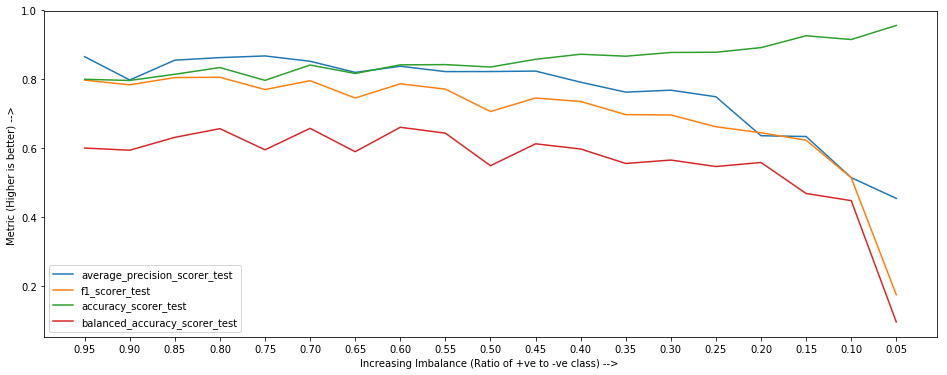

In [165]:

X,y = generate_data(data_size=10000)
score_dict,scores = imbalance_impact(build_model,[average_precision_scorer,f1_scorer,accuracy_scorer,balanced_accuracy_scorer],X,y)


## Exercise 1: Use your own scorer, model and check its behavior for Imbalance
- We will use Random Forest ALgorithm For this.
- For scorer we will define a new scorer to find roc_auc_score of our model.
- We will use a different dataset here.
- We will compare it to f1 and accuracy_scorers already provided in notebook.

In [210]:
# 1st lets build the model function
# define a build_model function which returns your desired model, each time a new instance 
def build_model(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier(n_estimators=10, max_depth=5)
    return classifier

In [211]:
# Next we define our new roc_auc_score scorer, 
# note our scorers have 3 params for genericness: true_labels,predicted_labels,predicted_probabilities

def roc_auc_scorer(y,y_pred,y_proba):
    from sklearn.metrics import roc_auc_score
    return roc_auc_score(y,y_proba)

In [212]:
# Lets use the titanic dataset from kaggle
# I have downloaded it and put it in the working dir. You can do the same for your dataset
X = pd.read_csv("titanic.csv")
y = X['Survived']
# drop the target column from X
df_utils.drop_columns_safely(X,['Survived'],inplace=True)
X['Sx'] = 0
X.loc[X['Sex']=="male",'Sx'] = 1
X = X[["Pclass","Sx","Age","Fare","SibSp"]]
X = X.fillna(X.median())

WARN: Data is already imbalanced! Imbalance = 0.6230 Try oversampling
WARN: Data is already imbalanced! Imbalance = 0.6230 Try oversampling
WARN: Data is already imbalanced! Imbalance = 0.6230 Try oversampling
WARN: Data is already imbalanced! Imbalance = 0.6230 Try oversampling
WARN: Data is already imbalanced! Imbalance = 0.6230 Try oversampling
WARN: Data is already imbalanced! Imbalance = 0.6230 Try oversampling
WARN: Data is already imbalanced! Imbalance = 0.6230 Try oversampling


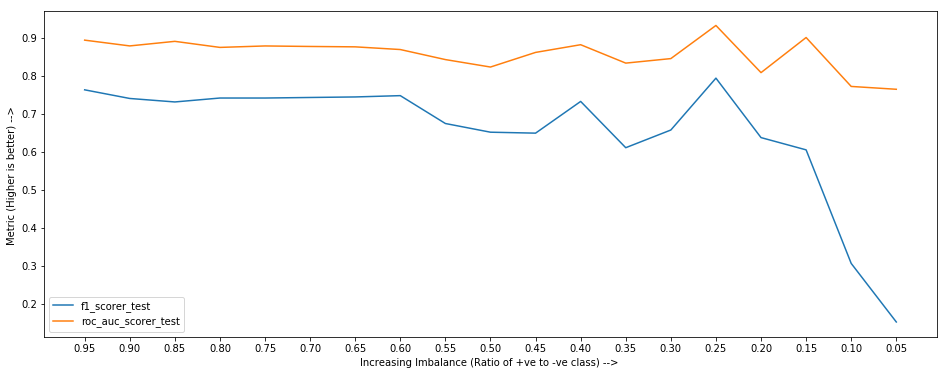

In [213]:
# Now we are going to run our function to plot effects of Imbalance

score_dict,scores = imbalance_impact(build_model,[f1_scorer,roc_auc_scorer],X,y)



## Exercise 2: Use other Data generators
- Here I just show few other data generators available in scikit for exploration. Use them along with tools provided in this Notebook to understand your algorithms behaviour

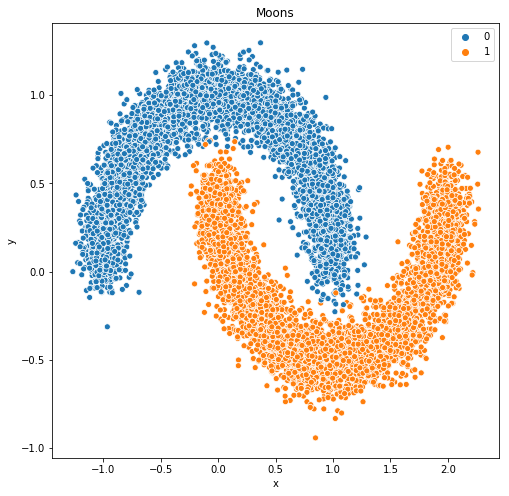

In [214]:
# Moons
from sklearn.datasets import make_moons

X,y = make_moons(10000,noise=0.1)
X = pd.DataFrame(X,columns=['x','y'])
y = pd.Series(y)

f, (ax1) = plt.subplots(nrows=1, ncols=1,figsize=(8,8))
sns.scatterplot(X['x'],X['y'],hue=y,ax=ax1);
ax1.set_title("Moons");
plt.show();

1    5006
0    4994
dtype: int64

Text(0.5, 1.0, 'Classification Data')

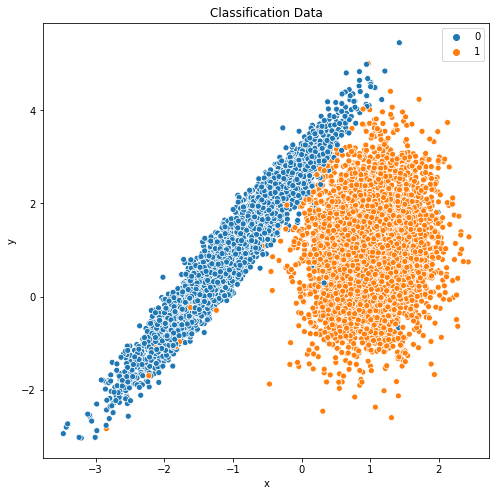

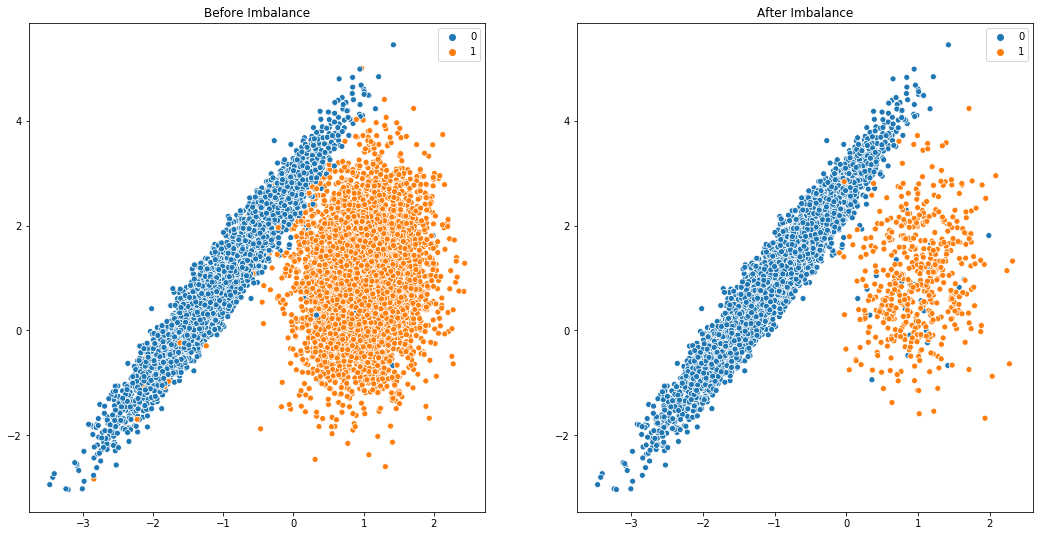

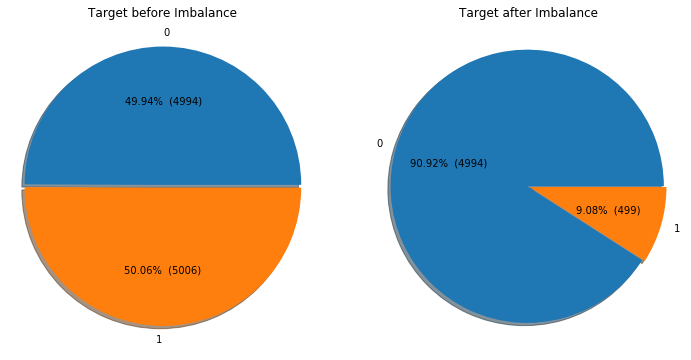

Plots Before and After Noise.


Number of Target Labels noised = 1098, Noise fraction=0.200

Best Possible Metrics:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      4208
           1       0.79      0.31      0.44      1285

   micro avg       0.82      0.82      0.82      5493
   macro avg       0.81      0.64      0.67      5493
weighted avg       0.81      0.82      0.79      5493



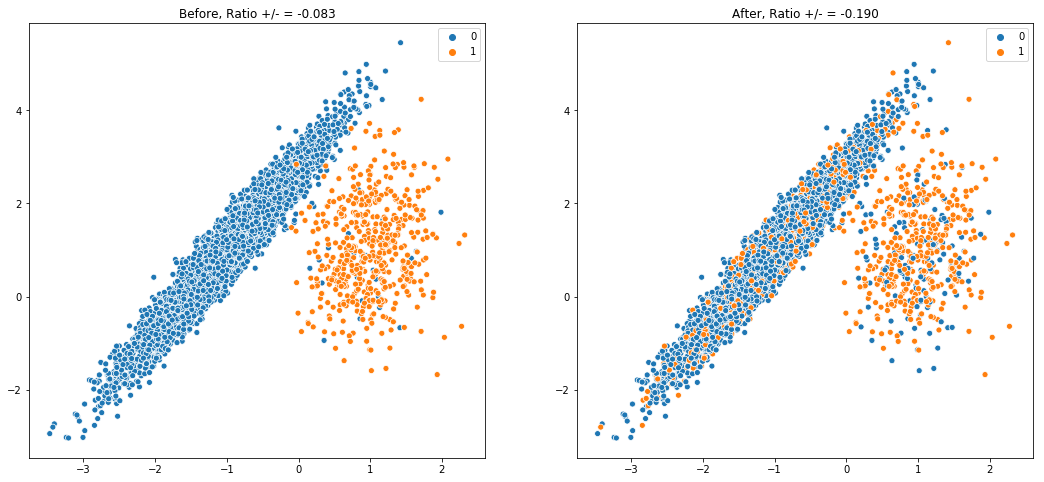

Plotting Imbalance and Noise after Oversampling


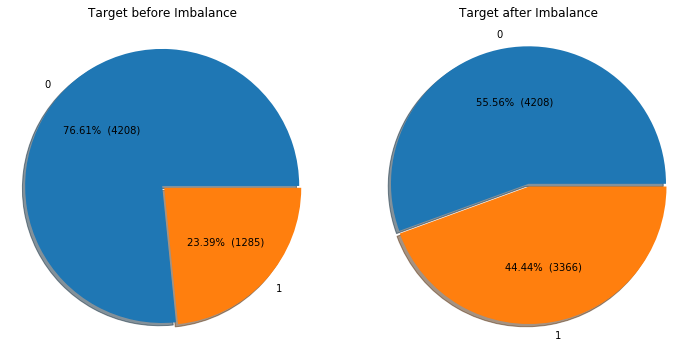

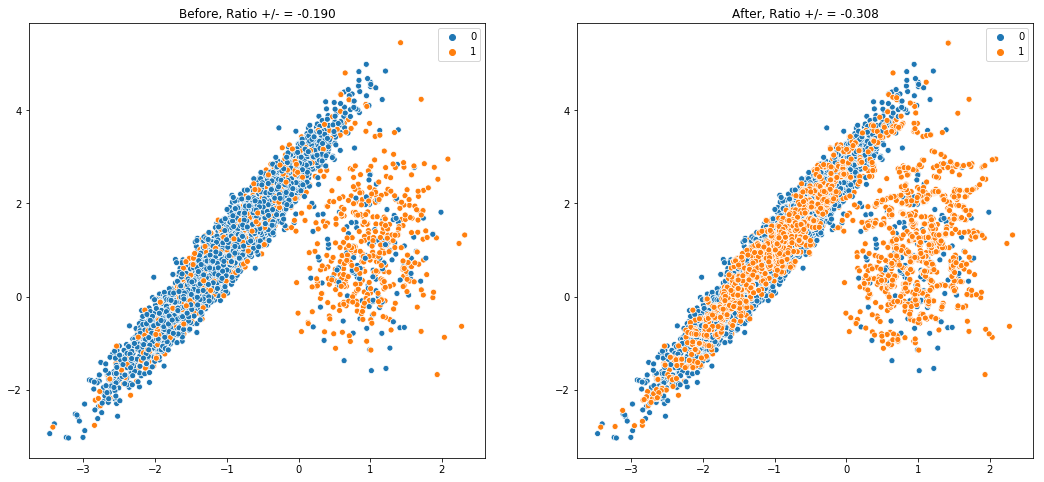

In [244]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=10000, n_features=2, n_informative=2, 
                    n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1,
                   flip_y=0.01,weights=[0.5,0.5])

X = pd.DataFrame(X,columns=['x','y'])
y = pd.Series(y)

y.value_counts()

f, (ax1) = plt.subplots(nrows=1, ncols=1,figsize=(8,8))
sns.scatterplot(X['x'],X['y'],hue=y,ax=ax1);
ax1.set_title("Classification Data");
plt.show();

X,y = imbalance(X,y,pos_neg_frac=0.1,plot=True)
X,y = add_noise(X,y,noise_level = 0.2,noise_type = "randomize_labels",plot=True)
X,y = oversample(X,y,pos_neg_frac=0.8,plot=True)



## Effect of oversampling strategies on Noisy Labels
- From Exercis 2 we understood that oversampling to reduce imbalance in noisy Labels could result in more noise in our Labels. In this section we will look at different oversampling strategies in presence of noise using 2-D Data.

In [ ]:
# We will make this Interactive
# Use your Dataset
# Choose a Imbalance Value
# Choose a Noise Value
# Choose a upsampling strategy and ratio
# Plot results of Before and After



# Interactive

## Generate or read data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Imbalance the Data

- What happens when imbalance if different in train and test data. We will imbalance train and test data separately for this.


## Make some Noise

- Realise how the model performs with incremental noise
- Realise what would happen if we removed some noise from data
    - If model performs bad just by adding little noise then our model is brittle to noise.
    - It means that if the real data had even 1% noise and we removed it then our model performance will increase a lot.
    
- What happens if Noise profile for your train and test data are different?
    - for example training data was gathered by experts in Lab but test data is gathered by IOT devices on field.

## Oversample

Why do we over-sample after adding noise?
In Real world your data will already come with some noise and this noise cannot be removed in our preprocessing. As such 

## Inspect your Data
- Imbalance/Noise

## Model

## Show Metrics (CV and Test)

## Learning Curves

# Appendix

## Finding Optimal Tress for XGBoost

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=63, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

<Figure size 1008x720 with 0 Axes>

Text(0.5,1,'Training and Test Loss (Last 3 Training): [0.13368, 0.13335, 0.13297] (Last 3 Test): [0.173011, 0.172681, 0.172473]')

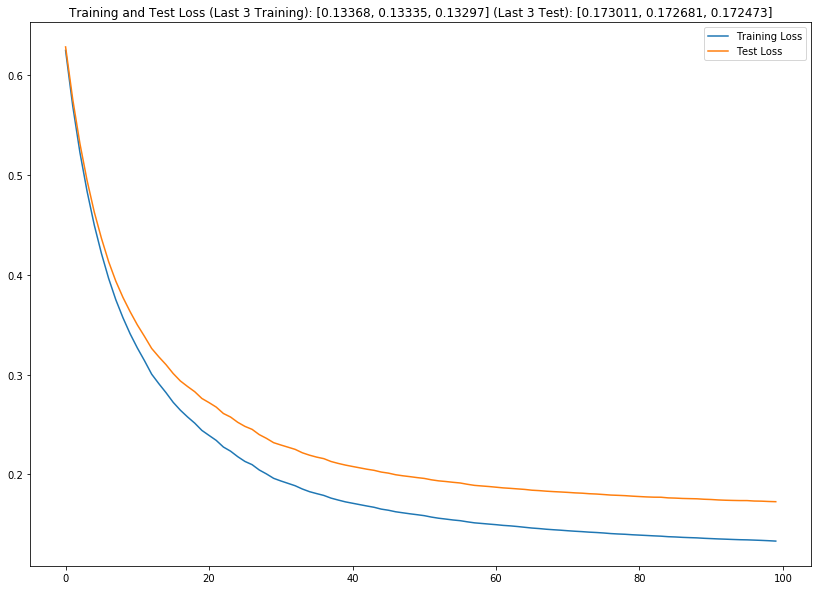

In [302]:


model = XGBClassifier(max_depth=3,n_estimators=100,learning_rate=0.1,
                              n_jobs=os.cpu_count()-1,scale_pos_weight=1)

training_loss = []
test_loss = []

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)
eval_set = [(X_tr, y_tr), (X_val, y_val)]
model.fit(X_tr, y_tr, eval_metric=["logloss"], eval_set=eval_set,verbose=False)
results = model.evals_result()
training_loss.extend(results['validation_0']['logloss'])
test_loss.extend(results['validation_1']['logloss'])


plt.figure(figsize=(14,10))
plt.plot(training_loss,label="Training Loss")
plt.plot(test_loss,label="Test Loss")
plt.title("Training and Test Loss (Last 3 Training): %s (Last 3 Test): %s"%(training_loss[-3:],test_loss[-3:]))
plt.legend()
plt.show()